In [30]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.feature_selection import SelectFromModel
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

%matplotlib inline
warnings.filterwarnings('ignore')

In [31]:
# Load Data Set to train
def loadData(data):
    dataDf = pd.read_csv(data)
    numCustomers = dataDf.shape[0]
    numfeatures = dataDf.shape[1]
    
    print('Total number of customers: {}'.format(numCustomers))
    print('Total number of features: {}'.format(numfeatures))
    
    return dataDf

In [32]:
train = loadData('data/train.csv')
test = loadData('data/test.csv')

Total number of customers: 76020
Total number of features: 371
Total number of customers: 75818
Total number of features: 370


In [33]:
# Removes constan columns with a std of zero
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

# Removes columns that are duplicates 
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True) 


In [34]:
X_train = train.drop(['TARGET', 'ID'], axis=1)
y_train = train.TARGET.values

In [35]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20)

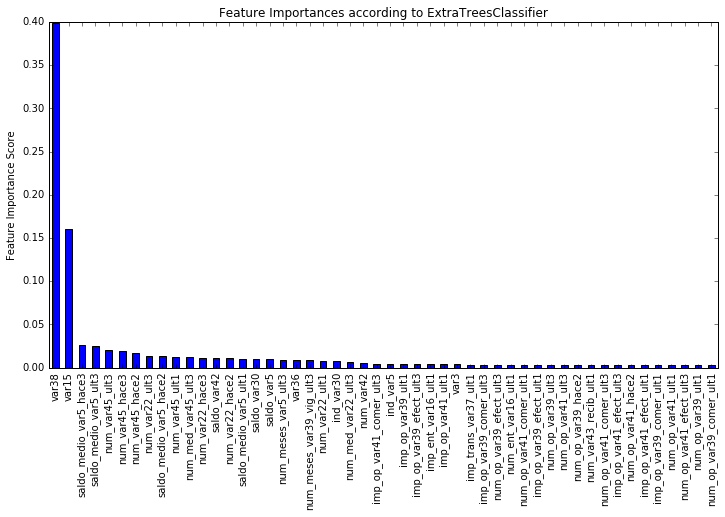

(60816, 42) (75818, 42)


In [37]:
featureSelect_clf = ExtraTreesClassifier(random_state=1729)
selector = featureSelect_clf.fit(X_train, y_train)

# plot most important features
feat_imp = pd.Series(featureSelect_clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:50].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('feature_imporatnce.png')
plt.show()

# Transforms data to the most important features 
featImports = SelectFromModel(selector, prefit=True)

X_train = featImports.transform(X_train)
X_test = featImports.transform(X_test)
test = featImports.transform(test)

print(X_train.shape, test.shape)

In [38]:
def trainModel(clf, X_train, y_train):
    print ("------------------------------------------")
    print ("\nClassifier: {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    scores = cross_validation.cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10) 
    end = time.time()
    print ("time (secs): {:.3f}".format(end - start))
    return scores.mean()

In [39]:
gnb = GaussianNB()
tree = RandomForestClassifier()
dTree = DecisionTreeClassifier()
logReg = linear_model.LogisticRegression()
gboost = ensemble.GradientBoostingClassifier()
xgb = xgb.XGBClassifier()
ada = AdaBoostClassifier()

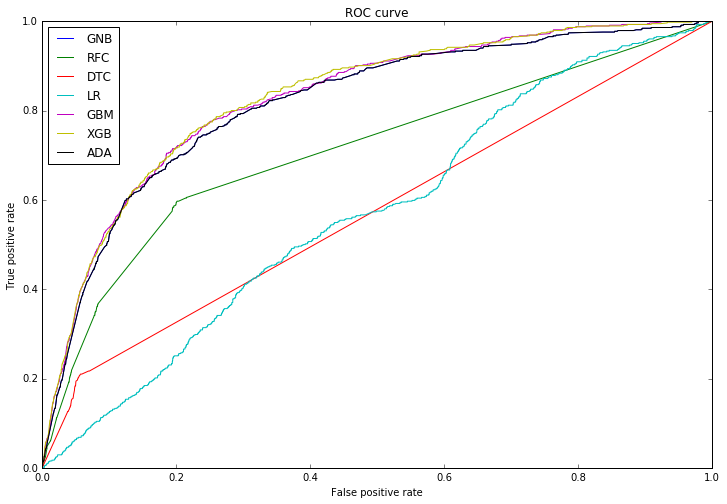

In [40]:
clfNames = ['GNB', 'RFC', 'DTC', 'LR', 'GBM', 'XGB', 'ADA']
clfList = [clf, tree, dTree,logReg, gboost, xgb, ada]

# Plots a ROC Curve of the list of models
plt.figure(figsize=(12,8))
for name,clf in zip(clfNames,clfList):

    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC_Curve.png')
plt.show() 

In [41]:
# training models to see which has th highest AUROC score
print ("ROC score for training set: {}".format(trainModel(gnb, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(tree, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(dTree, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(logReg, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(gboost, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(xgb, X_train, y_train)))
print ("ROC score for training set: {}".format(trainModel(ada, X_train, y_train)))


------------------------------------------

Classifier: GaussianNB...
time (secs): 0.353
ROC score for training set: 0.7454104597776043
------------------------------------------

Classifier: RandomForestClassifier...
time (secs): 6.298
ROC score for training set: 0.679731902555414
------------------------------------------

Classifier: DecisionTreeClassifier...
time (secs): 6.385
ROC score for training set: 0.57000827761143
------------------------------------------

Classifier: LogisticRegression...
time (secs): 34.094
ROC score for training set: 0.5804534897386138
------------------------------------------

Classifier: GradientBoostingClassifier...
time (secs): 80.627
ROC score for training set: 0.8369010039252307
------------------------------------------

Classifier: XGBClassifier...
time (secs): 18.140
ROC score for training set: 0.839890051502539
------------------------------------------

Classifier: AdaBoostClassifier...
time (secs): 27.823
ROC score for training set: 0.829316

In [42]:
print ("ROC score for test set: {}".format(trainModel(gnb, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(tree, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(dTree, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(logReg, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(gboost, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(xgb, X_test, y_test)))
print ("ROC score for test set: {}".format(trainModel(ada, X_test, y_test)))

------------------------------------------

Classifier: GaussianNB...
time (secs): 0.088
ROC score for test set: 0.625960616316668
------------------------------------------

Classifier: RandomForestClassifier...
time (secs): 1.329
ROC score for test set: 0.6771640834694439
------------------------------------------

Classifier: DecisionTreeClassifier...
time (secs): 1.230
ROC score for test set: 0.5645143283291644
------------------------------------------

Classifier: LogisticRegression...
time (secs): 8.220
ROC score for test set: 0.5826748640503788
------------------------------------------

Classifier: GradientBoostingClassifier...
time (secs): 14.899
ROC score for test set: 0.8217806261450266
------------------------------------------

Classifier: XGBClassifier...
time (secs): 5.674
ROC score for test set: 0.8261746582553309
------------------------------------------

Classifier: AdaBoostClassifier...
time (secs): 6.177
ROC score for test set: 0.8109924281854916


In [43]:
# Fine Tuned XGB Model
parameters = {'max_depth':[4],'min_child_weight':[9], 'gamma':[0.5], 'subsample':[0.8],
              'colsample_bytree':[0.6], 'reg_alpha':[1e-05], 'learning_rate':[0.1],
              'nthread':[0], 'n_estimators':[88],
              'seed':[93], 'objective':['binary:logistic']}

bestXGB = GridSearchCV(XGBClassifier(), parameters, scoring='roc_auc', cv=10 )

In [44]:
bestXGB.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'reg_alpha': [1e-05], 'n_estimators': [88], 'objective': ['binary:logistic'], 'min_child_weight': [9], 'max_depth': [4], 'subsample': [0.8], 'colsample_bytree': [0.6], 'gamma': [0.5], 'nthread': [0], 'seed': [93]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [45]:
trainModel(bestXGB, X_train, y_train)

------------------------------------------

Classifier: GridSearchCV...
time (secs): 176.592


0.84195212321643709

In [46]:
trainModel(bestXGB, X_test, y_test)

------------------------------------------

Classifier: GridSearchCV...
time (secs): 49.644


0.82519749761198502

In [47]:
proba = bestXGB.predict_proba(test)

In [48]:
# Submission dataframe for Kaggle Contest
submission = pd.DataFrame({"ID":test_id, "TARGET": proba[:,1]})
submission.head()
submission.to_csv("submission.csv", index=False)